#### Model taken from:
- [1] Offshore Pipelaying Dynamics. Gullik Anthon Jensen 
- [2] A nonlinear PDE formulation for offshore vessel pipeline installation. Gullik A. Jensen et al 
- [3] Modeling and Control of Offshore Pipelay Operations Based on a Finite Strain Pipe Model. Gullik A. Jensen 

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.optimize import fsolve
from scipy.integrate import solve_ivp
from scipy import interpolate

In [2]:
import sys
sys.path.insert(0, "../../../../Ocean_Intella/PythonVehicleSimulator-master/src/python_vehicle_simulator")
sys.path.insert(0, "../../../../Ocean_Intella/PythonVehicleSimulator-master/src")

In [3]:
from python_vehicle_simulator.vehicles import *
from python_vehicle_simulator.lib import *
from python_vehicle_simulator.lib.gnc import ssa

In [4]:
mp = 96       #  (submerged pipe weight) [kg/m]

In [5]:
node_N = 500

In [6]:
mi = [mp for i in range(node_N)] 

In [7]:
# L - the hull length
# Xg - x-center of gravity
L = 84.6 # [m]
B= 12
H= 13
Xg = L/2 # [m]
mn = 27_162_500 #123000000 # mass of the vessel, [kg]  
# kp, kd=1.95e4,1.5e4

In [8]:
lx,ly,lz=L/2,B/2,H/2

In [9]:
vessel_mass=mn/L # mass over length of the vessel

In [10]:
diag_Irho = 1e2*np.array([1, 1, 2]) # [m^4]  , p.99 in [1]
# diag_Irho = 1e-2*np.array([0.5, 0.5, 1])  # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Irho_=np.diag(diag_Irho)

In [11]:
Irho_

array([[100.,   0.,   0.],
       [  0., 100.,   0.],
       [  0.,   0., 200.]])

In [12]:
# Fossen book p.181
def vessel_inertia_moment(mn, Xg, L):
    r = 0.25*L
    Ir = mn*r**2
    Iz=mn*Xg**2 + Ir
    return Iz

In [13]:
vessel_inertia = vessel_inertia_moment(mn, Xg, L)

In [14]:
vessel_inertia

60751987031.24999

In [15]:
def inert(mn, vessel_inertia, Irho_, cum_d_inv, Ws):
    V_rho=np.zeros(Irho_.shape)
    np.fill_diagonal(V_rho, vessel_inertia)
    cum_m=0
    cum_i=0
    fin_123=[]
    for i in range(node_N-1,-1,-1):
        cum_m+=Ws[i]*cum_d_inv[i]**2
        cum_i+=Irho_
        fin_123.append(V_rho+cum_m + cum_i)
    return np.array(fin_123[::-1])

In [16]:
lll = [100 for i in range(node_N)]

In [17]:
cum_d_inv=[10]
sum_=0
for i in range(len(lll)-1,-1,-1):
    sum_+=lll[i]
    cum_d_inv.append(sum_)
cum_d_inv=cum_d_inv[::-1]    

In [18]:
cum_d_inv

[50000,
 49900,
 49800,
 49700,
 49600,
 49500,
 49400,
 49300,
 49200,
 49100,
 49000,
 48900,
 48800,
 48700,
 48600,
 48500,
 48400,
 48300,
 48200,
 48100,
 48000,
 47900,
 47800,
 47700,
 47600,
 47500,
 47400,
 47300,
 47200,
 47100,
 47000,
 46900,
 46800,
 46700,
 46600,
 46500,
 46400,
 46300,
 46200,
 46100,
 46000,
 45900,
 45800,
 45700,
 45600,
 45500,
 45400,
 45300,
 45200,
 45100,
 45000,
 44900,
 44800,
 44700,
 44600,
 44500,
 44400,
 44300,
 44200,
 44100,
 44000,
 43900,
 43800,
 43700,
 43600,
 43500,
 43400,
 43300,
 43200,
 43100,
 43000,
 42900,
 42800,
 42700,
 42600,
 42500,
 42400,
 42300,
 42200,
 42100,
 42000,
 41900,
 41800,
 41700,
 41600,
 41500,
 41400,
 41300,
 41200,
 41100,
 41000,
 40900,
 40800,
 40700,
 40600,
 40500,
 40400,
 40300,
 40200,
 40100,
 40000,
 39900,
 39800,
 39700,
 39600,
 39500,
 39400,
 39300,
 39200,
 39100,
 39000,
 38900,
 38800,
 38700,
 38600,
 38500,
 38400,
 38300,
 38200,
 38100,
 38000,
 37900,
 37800,
 37700,
 37600,


In [19]:
Ws = np.array(mi)*9.81

In [20]:
Irho=inert(mn, vessel_inertia, Irho_, cum_d_inv, Ws)
# Irho=np.array(fin_123)

In [21]:
# Irho+=vessel_inertia

In [22]:
Irho[-1][0][0]

60761404731.24999

In [23]:
Irho[-49][0][0]

441458471931.25

In [24]:
Irho

array([[[3.93638737e+14, 3.93577985e+14, 3.93577985e+14],
        [3.93577985e+14, 3.93638737e+14, 3.93577985e+14],
        [3.93577985e+14, 3.93577985e+14, 3.93638737e+14]],

       [[3.91284337e+14, 3.91223585e+14, 3.91223585e+14],
        [3.91223585e+14, 3.91284337e+14, 3.91223585e+14],
        [3.91223585e+14, 3.91223585e+14, 3.91284337e+14]],

       [[3.88939345e+14, 3.88878593e+14, 3.88878593e+14],
        [3.88878593e+14, 3.88939345e+14, 3.88878593e+14],
        [3.88878593e+14, 3.88878593e+14, 3.88939345e+14]],

       ...,

       [[6.08838337e+10, 1.31846400e+08, 1.31846400e+08],
        [1.31846400e+08, 6.08838337e+10, 1.31846400e+08],
        [1.31846400e+08, 1.31846400e+08, 6.08838340e+10]],

       [[6.07990752e+10, 4.70880000e+07, 4.70880000e+07],
        [4.70880000e+07, 6.07990752e+10, 4.70880000e+07],
        [4.70880000e+07, 4.70880000e+07, 6.07990754e+10]],

       [[6.07614047e+10, 9.41760000e+06, 9.41760000e+06],
        [9.41760000e+06, 6.07614047e+10, 9.417600

In [25]:
qw = 1025 # Water density [kg/m3]
d0 = 0.761 # Outer diameter of pipe, [m]
dI= 0.69 # Inner diameter of pipe, [m]

In [26]:
Ar=math.pi*((d0/2)**2-(dI/2)**2)

In [27]:
math.pi*(d0**4-dI**4)/64

0.005336285849082509

In [28]:
E = 210e9

In [29]:
E*Ar/1e10

1.6991625880187402

In [30]:
diag_DT = 1.5*np.array([1, 1, 1]) 

In [31]:
DT=np.diag(diag_DT) # (35) in [2]

In [32]:
DT

array([[1.5, 0. , 0. ],
       [0. , 1.5, 0. ],
       [0. , 0. , 1.5]])

In [33]:
# diag_CT = 1e9*np.array([1, 1, 1]) # [Nm2] p. 4721 in [3]
diag_CT = 1e10*np.array([1.7, 1.7, 1.7]) # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

In [34]:
CT=np.diag(diag_CT)

In [35]:
CT

array([[1.7e+10, 0.0e+00, 0.0e+00],
       [0.0e+00, 1.7e+10, 0.0e+00],
       [0.0e+00, 0.0e+00, 1.7e+10]])

In [36]:
# angles should be in radians, otherwise np.radians them  
def Re_t_(arr):
    φ,θ,ψ=arr[0],arr[1],arr[2]
  
    Cφ=np.matrix([[1,0,0],
                      [0,np.cos(φ),-np.sin(φ)],
                      [0,np.sin(φ),np.cos(φ)]])

    Cθ=np.matrix([[np.cos(θ),0,np.sin(θ)],
                      [0,1,0],
                      [-np.sin(θ),0,np.cos(θ)]])

    Cψ=np.matrix([[np.cos(ψ),-np.sin(ψ),0],
                      [np.sin(ψ),np.cos(ψ),0],
                      [0,0,1]])
        

    return np.array(np.dot(np.dot(Cθ,Cφ),Cψ) )

In [37]:
Re_t_([1,2,3])

array([[ 0.51995985, -0.69876354,  0.4912955 ],
       [ 0.07624747, -0.53489523, -0.84147098],
       [ 0.85078086,  0.47499117, -0.2248451 ]])

In [38]:
rng = np.random.default_rng()

In [39]:
φ, θ, ψ = rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [40]:
def Re_t(a,b,c):
    xyz=np.stack((a,b,c), axis=1)
    return np.apply_along_axis(Re_t_, 1, xyz)

In [41]:
Re_t_(np.array([φ[1], θ[1], ψ[1]]))

array([[ 0.51743849, -0.14068308,  0.84407682],
       [ 0.66406936,  0.68812382, -0.29239954],
       [-0.5396937 ,  0.71182433,  0.44948508]])

In [42]:
startTime1 = datetime.now()
Ret=Re_t(φ,θ,ψ)
print(datetime.now() - startTime1)

0:00:00.068507


In [43]:
Ret.shape

(500, 3, 3)

In [44]:
dx,dy,dz=rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [45]:
def C1(dx,dy,dz, Ret): # here
    B=np.vstack([np.abs(dx)*dx,(dy**2+dz**2)**0.5*dy,(dy**2+dz**2)**0.5*dz])
    ans=np.einsum('ijk,ik->ij', Ret, np.linalg.solve(Ret,B.T.astype(np.float64)))  
#     print(Ret[0].shape, B.T[0].shape)
#     print(np.linalg.solve(Ret[0],B.T[0].astype(np.float64)).shape)
#     ans=[]
#     for i in range(len(B.T)):
#         ans.append(np.dot(Ret[i],np.linalg.solve(Ret[i],B.T[i].astype(np.float64))))
#         print(ans[-1])
#     ans=np.tensordot(Ret, np.linalg.solve(Ret,B.T.astype(np.float64)),axes = 0)
    return np.array(ans).T

In [46]:
startTime1 = datetime.now()
C1(dx,dy,dz,Ret)
print(datetime.now() - startTime1)

0:00:00.001932


In [47]:
C1(dx,dy,dz,Ret)

array([[ 0.28982832,  3.15694304,  0.65438653, ...,  0.01710493,
        -3.02802291,  4.21648357],
       [ 0.42050894, -1.45002582, -1.83513977, ..., -1.81546419,
         0.06335735,  1.02626046],
       [ 1.13148475, -5.84209922,  0.91942936, ..., -0.86364874,
         0.11042216, -0.30808575]])

In [48]:
def fD(dx,dy,dz,DT,Ret):
    return 1/2*d0*qw*np.dot(DT, C1(dx,dy,dz,Ret))*9.81

In [49]:
fD(dx,dy,dz,DT,Ret).T

array([[  1663.33454079,   2413.31506721,   6493.62935523],
       [ 18117.80326459,  -8321.74739069, -33528.00571461],
       [  3755.54652682, -10531.92944868,   5276.63630979],
       ...,
       [    98.16575975, -10419.01057896,  -4956.5094056 ],
       [-17377.92623601,    363.61000238,    633.71654415],
       [ 24198.54229143,   5889.74361228,  -1768.11455334]])

In [50]:
startTime1 = datetime.now()
fD(dx,dy,dz,DT,Ret)
print(datetime.now() - startTime1)

0:00:00.000473


In [51]:
# https://docs.scipy.org/doc/scipy-1.8.0/tutorial/integrate.html  
# 1-D Gray-Scott 

In [52]:
I=np.identity(3)

In [53]:
startTime1 = datetime.now()
np.dot(I,fD(dx,dy,dz,DT,Ret))
print(datetime.now() - startTime1)

0:00:00.000528


In [54]:
Rb_t=I # https://www.researchgate.net/profile/Thor-Fossen/publication/224560837_Modeling_and_Control_of_Offshore_Pipelay_Operations_Based_on_a_Finite_Strain_Pipe_Model/links/00b7d520e175a3f918000000/Modeling-and-Control-of-Offshore-Pipelay-Operations-Based-on-a-Finite-Strain-Pipe-Model.pdf

In [55]:
Rb_t

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [56]:
diag_DR = 1.5*np.array([1, 1, 1]) # [N m/rad]  p.4721 in [3]

In [57]:
DR=np.diag(diag_DR) 

In [58]:
Ar

0.08091250419136858

In [59]:
fg_e=np.array([[0,0,(mp-qw*Ar)*9.81] for x in range(node_N)])

In [60]:
fg_e

array([[  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       ...,
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223]])

In [61]:
x,y,z=rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [62]:
def Re_b(Ret):
    return Ret

In [63]:
startTime1 = datetime.now()
Re_b(Ret)
print(datetime.now() - startTime1)

0:00:00.001045


In [64]:
def phi(x, y, z, Ret,dummy,dummy1): # here
    B=np.vstack([x,y,z])
    return np.linalg.solve(Ret.astype(np.float64),B.T.astype(np.float64))
#     return np.einsum('ijk,ik->ij', Ret,B.T.astype(np.float64))

In [65]:
phi(x,y,z,Ret,None,None)

array([[-1.03012383, -0.51415338, -1.06774053],
       [ 0.55166852, -1.14099191, -0.62872763],
       [ 1.17795328,  0.25467125,  0.12141994],
       ...,
       [-0.24587926,  0.42776515,  0.20840347],
       [-1.51718965, -0.03685857,  0.55745033],
       [-0.16564865, -0.32144843, -1.07987138]])

In [66]:
startTime1 = datetime.now()
phi(x,y,z,Ret,None,None)
print(datetime.now() - startTime1)

0:00:00.000368


In [67]:
def Π_(arr):
    φ,θ,ψ=arr[0],arr[1],arr[2]
    return np.array([[np.cos(θ),0,np.cos(φ)*np.sin(θ)],
                  [0,1,-np.sin(φ)],
                  [-np.sin(θ),0,np.cos(φ)*np.cos(θ)]])

In [68]:
def Π(a,b,c):
    xyz=np.stack((a,b,c), axis=1)
  
    return np.apply_along_axis(Π_, 1, xyz)
    

In [69]:
startTime1 = datetime.now()
Π(φ,θ,ψ).shape
print(datetime.now() - startTime1)

0:00:00.016528


In [70]:
def ωe(φ,θ,ψ, dummy,dummy1,dummy2): # here # (100) in [2]
    A=Π(φ,θ,ψ)
    B=np.vstack([φ,θ,ψ])
    return np.einsum('ijk,ik->ij',A,B.T.astype(np.float64))

In [71]:
startTime1 = datetime.now()
ωe(φ,θ,ψ,None,None,None)
print(datetime.now() - startTime1)

0:00:00.018605


In [72]:
ωe(φ,θ,ψ,None,None,None)

array([[-0.90491575, -0.32945979, -1.50676637],
       [ 0.787396  ,  0.85702589,  0.08311579],
       [-0.5602986 , -0.84071518,  1.19669097],
       ...,
       [ 0.25476693, -0.93595709, -0.07052482],
       [-2.66107959, -1.13538483, -1.43122923],
       [-0.33092319,  1.44048088, -0.27938005]])

In [73]:
def d_s(f,a,b,c,Ret,omega): # here
    
    fun = f(a,b,c,Ret,omega, None) 
    
#     if flag==1:
#         fun+=-np.dot(Ret,force)
# #         fun*=-np.dot(Ret,force)
#     elif flag==2:
#         fun+=-np.dot(np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float64)),Re_b(Ret)),force)
#         fun*=-np.dot(np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float64)),Re_b(Ret)),force)
#     print(np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float64)),Re_b(Ret)))
#     print(np.dot(np.linalg.inv(Π(φ,θ,ψ).astype(np.float64))[2],Re_b(Ret)[2]))
        
# #     print(fun)
#     if any(force):
# #         fun[-1]=-np.array(force)
#         fun[-1]=-np.dot(Ret[-1],force)
# #         fun+=-np.dot(Ret,force) # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# #     print(fun)

    def S(arr):
        a1,a2,a3=arr[0],arr[1],arr[2]
        return np.array([[0, -a3, a2 ],
                         [a3, 0, -a1],
                        [-a2, a1, 0]])
    K=np.apply_along_axis(S, 1, omega)
    
    
   
    return np.einsum('ijk,ik->ij',K, fun.astype(np.float64)).T

In [74]:
φ, θ, ψ = np.array([0.00001 for i in range(node_N)]),np.array([0.00001 for i in range(node_N)]),np.array([0.00001 for i in range(node_N)])

In [75]:
d_s(phi,x,y,z,Ret, ωe(φ,θ,ψ,None,None,None))

array([[-5.53581618e-06,  5.12259156e-06, -1.33249979e-06, ...,
        -2.19359486e-06,  5.94302960e-06, -7.58415364e-06],
       [ 3.76376839e-07,  1.18039692e-05,  1.05652034e-05, ...,
        -4.54282351e-06, -2.07463038e-05,  9.14235184e-06],
       [ 5.15955006e-06, -1.69266632e-05, -9.23267696e-06, ...,
         6.73646225e-06,  1.48031554e-05, -1.55804651e-06]])

In [76]:
startTime1 = datetime.now()
d_s(phi,x,y,z,Ret,ωe(φ,θ,ψ,None,None,None))
print(datetime.now() - startTime1)

0:00:00.011886


In [77]:
def ne(x,y,z,Ret,omega,force): # here
    A=np.multiply(np.multiply(Ret,CT),Ret)
    B=d_s(phi,x,y,z,Ret,omega).T
    return np.einsum('ijk,ik->ij', A.astype(np.float64),B
                     -
                     np.einsum('ijk,kp->ijp',Ret.astype(np.float64), np.array([1,0,0]).reshape(3,1)).squeeze()
                    )

In [78]:
# np.dot(Ret.astype(np.float64)[2],np.array([1,0,0]).reshape(3,1)).squeeze()

In [79]:
# np.einsum('ijk,kp->ijp',Ret.astype(np.float64), np.array([1,0,0]).reshape(3,1)).squeeze()

In [80]:
φ, θ, ψ = np.array([0.000001 for i in range(node_N)]),np.array([0.000001 for i in range(node_N)]),np.array([0.000001 for i in range(node_N)])

In [81]:
d_s(ωe,x,y,z,Ret,ωe(φ,θ,ψ,None,None,None))

array([[-3.19957673e-07, -1.01633228e-06, -9.34876404e-07, ...,
        -3.11014774e-07,  4.84439003e-07, -2.07566310e-08],
       [ 3.40633873e-08,  1.60975317e-06, -6.30123874e-08, ...,
        -3.90727224e-07,  1.53788599e-06, -1.14315383e-06],
       [ 2.85894926e-07, -5.93418852e-07,  9.97890661e-07, ...,
         7.01742620e-07, -2.02232597e-06,  1.16391050e-06]])

In [82]:
def ne_(dx,dy,dz,DT,Ret):
    return -fg_e.T-fD(dx,dy,dz,DT,Ret) #-sigma(x,y,z).T

In [83]:
ne_(dx,dy,dz,DT,Ret)

array([[ -1663.33454079, -18117.80326459,  -3755.54652682, ...,
           -98.16575975,  17377.92623601, -24198.54229143],
       [ -2413.31506721,   8321.74739069,  10531.92944868, ...,
         10419.01057896,   -363.61000238,  -5889.74361228],
       [ -6621.79389746,  33399.84117238,  -5404.80085202, ...,
          4828.34486337,   -761.88108638,   1639.95001111]])

In [84]:
startTime1 = datetime.now()
ne(x,y,z,Ret,ωe(φ,θ,ψ,None,None,None),[0,0,1])
print(datetime.now() - startTime1)

0:00:00.022078


In [85]:
d_s(ne, x, y, z, Ret, ωe(φ,θ,ψ,None,None,None)).T

array([[   -97.75903691, -14125.18584816,  14222.9450806 ],
       [  7199.21243695,  -4208.82298705,  -2990.40384834],
       [ -2385.15850296,   3244.62175157,   -859.4584783 ],
       ...,
       [ -8252.3238345 ,   1116.76495099,   7135.57538818],
       [  -579.95972456,   3726.70626912,  -3146.74538465],
       [ -4540.89237066,   -676.1263752 ,   5217.02782766]])

In [86]:
ne(x,y,z,Ret,ωe(φ,θ,ψ,None,None,None),[1,23,4])

array([[-1.41836835e+10,  3.92757024e+07, -5.84834322e+07],
       [-2.35518318e+09, -5.34557933e+09,  1.85364030e+09],
       [-1.42093798e+07, -8.73666970e+08, -3.25882786e+09],
       ...,
       [-3.23405158e+09,  3.90152314e+09, -4.35080895e+09],
       [-5.70666241e+07, -3.20380875e+09, -3.78376905e+09],
       [-2.71275633e+07,  5.18989510e+09,  6.48998190e+08]])

In [87]:
startTime1 = datetime.now()
ne_(dx,dy,dz,DT,Ret)
print(datetime.now() - startTime1)

0:00:00.000608


In [88]:
Re_b(Ret).shape

(500, 3, 3)

In [89]:
# def Irho_e(Ret):
    
#     ans1 = np.multiply(np.multiply(Ret,Irho),Ret) # (19) in [3] 
    
#     sum_=np.zeros(Irho.shape)
# #     print(sum_)
    
#     for i in range(len(ans1)):
#         sum_+=ans1[i]
#         ans1[i]=sum_
        
#     tmp=np.zeros(Irho.shape)
#     np.fill_diagonal(tmp, vessel_inertia)
    
#     ans2=np.multiply(np.multiply(Ret,tmp),Ret)
#     ans1[-1]+=ans2[-1]
    
#     for i in range(int(node_N/4)):
#         ans1[i]*=(10-i+1)
#     return ans1
def Irho_e(Ret,Irho): # here
#     ans= np.multiply(np.multiply(Ret,Irho),Ret) # (19) in [3] 
#     print(Irho[1])
#     print(np.dot(np.dot(Ret[1],Irho[1]),Ret[1]))
    ans=  np.einsum('ijk,ikp->ijp', np.einsum('ijk,ikp->ijp', Ret,Irho),Ret)
    return ans

In [90]:
Irho_e(Ret,Irho)

array([[[ 6.31266372e+14, -4.30437386e+14,  5.64136312e+14],
        [ 3.30149108e+14, -2.25186870e+14,  2.95024395e+14],
        [-3.29281521e+14,  2.24583091e+14, -2.94350052e+14]],

       [[ 3.06525140e+14,  6.01474319e+14,  4.78225609e+14],
        [ 2.66164814e+14,  5.22122233e+14,  4.15112049e+14],
        [ 1.56080264e+14,  3.06295394e+14,  2.43445355e+14]],

       [[-6.65507562e+14,  5.49495977e+14, -4.21378047e+13],
        [ 5.15399434e+14, -4.25617953e+14,  3.25759129e+13],
        [ 3.14433656e+14, -2.59700925e+14,  1.99389635e+13]],

       ...,

       [[-1.96248604e+10, -5.76160591e+09, -5.72094865e+10],
        [-2.71671509e+10,  5.42590044e+10,  3.88452594e+09],
        [ 5.08662401e+10,  2.72078303e+10, -2.01133731e+10]],

       [[ 5.93576206e+10,  9.84124295e+09, -9.18426374e+09],
        [-7.04895333e+09,  5.81620147e+10,  1.61450133e+10],
        [ 1.14439694e+10, -1.46434921e+10,  5.78489640e+10]],

       [[-5.87021402e+10, -3.02911105e+09,  1.54186320e+10],
 

In [91]:
startTime1 = datetime.now()
Irho_e(Ret,Irho)
print(datetime.now() - startTime1)

0:00:00.001069


In [92]:
79.3*1e9*math.pi*(d0**4-dI**4)/64

423167467.8322429

In [93]:
# diag_CR = 1e11*np.array([1, 1, 1])
diag_CR = 1e9*np.array([4, 4, 4]) #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

CR=np.diag(diag_CR)

In [94]:
CR

array([[4.e+09, 0.e+00, 0.e+00],
       [0.e+00, 4.e+09, 0.e+00],
       [0.e+00, 0.e+00, 4.e+09]])

In [95]:
def d_me(φ,θ,ψ,Ret,fun,omega):
    A=np.multiply(np.multiply(Ret,CR),Ret)
    B=d_s(fun,φ,θ,ψ,Ret.astype(np.float32),omega.astype(np.float32))

    return np.einsum('ijk,ik->ij', A,B.T.astype(np.float32)) 

In [96]:
startTime1 = datetime.now()
d_me_=d_me(φ,θ,ψ,Ret,ωe, ωe(φ,θ,ψ,None,None,None))
print(datetime.now() - startTime1)

0:00:00.045415


In [97]:
d_me_

array([[-3.54520155e-15, -3.92071690e-12,  1.99961507e-12],
       [-1.07102225e-15, -8.78134052e-11,  3.74686064e-11],
       [-3.54948014e-17, -9.99543087e-12,  1.24184477e-10],
       ...,
       [-1.32316173e-15, -1.72732391e-10,  6.08448149e-11],
       [-8.96818068e-17, -4.20714806e-11,  7.69857850e-11],
       [-5.46244475e-17, -1.52116445e-10,  7.68916625e-12]])

In [98]:
# diag_DR = 1.5*np.array([1, 1, 1]) 
 
# DR=np.diag(diag_DR)

In [99]:
ne_(dx,dy,dz,DT,Ret)

array([[ -1663.33454079, -18117.80326459,  -3755.54652682, ...,
           -98.16575975,  17377.92623601, -24198.54229143],
       [ -2413.31506721,   8321.74739069,  10531.92944868, ...,
         10419.01057896,   -363.61000238,  -5889.74361228],
       [ -6621.79389746,  33399.84117238,  -5404.80085202, ...,
          4828.34486337,   -761.88108638,   1639.95001111]])

### Static solution

In [100]:
def catenary(x,Ws,Fh):
    return (Fh/Ws)*(np.cosh(x*Ws/Fh)-1)

In [101]:
pipe_weight_per_unit_length = mi #  (submerged) [kg/m]  # 113.07 - not submerged

In [102]:
Fx_0=82945396

In [103]:
Ws = np.array(pipe_weight_per_unit_length)*9.81 # [N/m]
h=700

In [104]:
S=math.sqrt(h*(2*Fx_0/Ws[0] -h))
horizontal_length=(Fx_0/Ws[0] -h)*np.log((S+Fx_0/Ws[0])/(Fx_0/Ws[0]-h))

In [105]:
Ws

array([941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
      

In [106]:
delta_x=horizontal_length/(node_N-1)

In [107]:
x0=[i*delta_x for i in range(node_N)]
z0=[]

for i in range(len(x0)):
    z0.append(catenary(x0[i],Ws[0],Fx_0))

length_p=[]
for i in range(1,len(z0)):
    length_p.append(math.sqrt((x0[i]-x0[i-1])**2+(z0[i]-z0[i-1])**2))

In [108]:
M_totl=[]
v_mass=vessel_mass*9.81
for i in range(node_N):
    v_mass+=Ws[i]
    M_totl.append(v_mass)
M_totl=np.array(M_totl[::-1])

In [109]:
M_totl

array([3620574.14893606, 3619632.38893606, 3618690.62893606,
       3617748.86893606, 3616807.10893606, 3615865.34893606,
       3614923.58893606, 3613981.82893606, 3613040.06893606,
       3612098.30893606, 3611156.54893606, 3610214.78893606,
       3609273.02893606, 3608331.26893606, 3607389.50893606,
       3606447.74893606, 3605505.98893606, 3604564.22893606,
       3603622.46893606, 3602680.70893606, 3601738.94893606,
       3600797.18893606, 3599855.42893606, 3598913.66893606,
       3597971.90893606, 3597030.14893606, 3596088.38893606,
       3595146.62893606, 3594204.86893607, 3593263.10893607,
       3592321.34893607, 3591379.58893607, 3590437.82893607,
       3589496.06893607, 3588554.30893607, 3587612.54893607,
       3586670.78893607, 3585729.02893607, 3584787.26893607,
       3583845.50893607, 3582903.74893607, 3581961.98893607,
       3581020.22893607, 3580078.46893607, 3579136.70893607,
       3578194.94893607, 3577253.18893607, 3576311.42893607,
       3575369.66893607,

In [110]:
x0,z0

([0.0,
  22.149669026977197,
  44.29933805395439,
  66.4490070809316,
  88.59867610790879,
  110.74834513488598,
  132.8980141618632,
  155.04768318884038,
  177.19735221581757,
  199.34702124279477,
  221.49669026977196,
  243.64635929674915,
  265.7960283237264,
  287.94569735070354,
  310.09536637768076,
  332.2450354046579,
  354.39470443163515,
  376.54437345861237,
  398.69404248558953,
  420.84371151256676,
  442.9933805395439,
  465.14304956652114,
  487.2927185934983,
  509.44238762047553,
  531.5920566474528,
  553.74172567443,
  575.8913947014071,
  598.0410637283843,
  620.1907327553615,
  642.3404017823387,
  664.4900708093159,
  686.6397398362931,
  708.7894088632703,
  730.9390778902475,
  753.0887469172247,
  775.2384159442018,
  797.3880849711791,
  819.5377539981563,
  841.6874230251335,
  863.8370920521106,
  885.9867610790878,
  908.1364301060651,
  930.2860991330423,
  952.4357681600195,
  974.5854371869966,
  996.7351062139738,
  1018.8847752409511,
  1041.0344442

In [111]:
length_p

[22.149669202085867,
 22.149670602955247,
 22.149673404694106,
 22.149677607302575,
 22.149683210780992,
 22.149690215129667,
 22.149698620349017,
 22.149708426439652,
 22.149719633402146,
 22.14973224123716,
 22.14974624994558,
 22.14976165952827,
 22.149778469986096,
 22.149796681320375,
 22.149816293531906,
 22.149837306622285,
 22.149859720592605,
 22.149883535444275,
 22.14990875117897,
 22.149935367798147,
 22.149963385303725,
 22.14999280369694,
 22.15002362298029,
 22.150055843155343,
 22.15008946422431,
 22.150124486188954,
 22.15016090905208,
 22.150198732815515,
 22.15023795748204,
 22.150278583053463,
 22.15032060953326,
 22.15036403692361,
 22.150408865227057,
 22.15045509444658,
 22.15050272458549,
 22.1505517556463,
 22.150602187632447,
 22.15065402054689,
 22.150707254392966,
 22.150761889174195,
 22.15081792489388,
 22.15087536155547,
 22.15093419916281,
 22.150994437719493,
 22.151056077229462,
 22.151119117696485,
 22.151183559124323,
 22.15124940151796,
 22.15131664

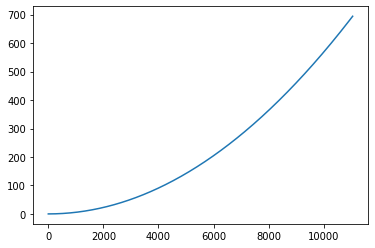

In [112]:
plt.plot(x0, z0)
plt.show()

In [113]:
rng = np.random.default_rng(seed=29)
q0=np.zeros(12*node_N)

In [114]:
for j in range(1,12):
    if j==1:  
        q0[(j-1)*node_N:j*node_N]=x0
    elif j==5:    
        q0[(j-1)*node_N:j*node_N]=z0

In [115]:
def static_func(Q): # here
    t=0
 
    x,y,z=Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]
    dx,dy,dz=Q[1*node_N:2*node_N],Q[3*node_N:4*node_N],Q[5*node_N:6*node_N]
    φ,θ,ψ=Q[6*node_N:7*node_N],Q[8*node_N:9*node_N],Q[10*node_N:11*node_N]
    Ret = Re_t(φ,θ,ψ)

    
    dφ,dθ,dψ=Q[7*node_N:8*node_N],Q[9*node_N:10*node_N],Q[11*node_N:12*node_N]
    
    η=[x[-1],y[-1],z[-1],φ[-1],θ[-1],ψ[-1]]
    
    tau_force=np.array([-Fx_0,0,0,0,0,0])
    Z0=np.dot(Re_b(Ret),tau_force[:3])
    Z1 = d_s(ne, x, y, z, Ret, ωe(φ,θ,ψ,None,None,None)).T
#     test=np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float64),np.array([dφ,dθ,dψ]).astype(np.float64).T)

#     Z1 = d_s(ne, x, y, z, Ret, test).T
    DT_0=np.zeros((3,3))
    Z2=ne_(dx,dy,dz,DT_0,Ret).T
    
    
    Z =  Z1 + Z2 + Z0
    
    
############################################################ 
    ddx,ddy, ddz = np.linalg.solve(np.einsum('i,ijk->ijk',M_totl,Re_b(Ret)),Z).T
    ddx,ddy, ddz = np.einsum('ijk,ik->ij',Ret, np.stack([ddx, ddy,ddz], axis=0).T).T

############################################################ 

    sum_0123=0
    lll=[]
    for i in range(1,len(z0)):
        sum_0123=math.sqrt((x[i]-x[i-1])**2+(y[i]-y[i-1])**2+(z[i]-z[i-1])**2)
        lll.append(sum_0123)
        
    cum_d_inv=[0]
    sum_=0
    for i in range(len(lll)-1,-1,-1):
        sum_+=lll[i]
        cum_d_inv.append(sum_)
    cum_d_inv=cum_d_inv[::-1] 
     
    
    Irho=inert(mn, vessel_inertia, Irho_, cum_d_inv, Ws)
    
    
    C0=np.einsum('ijk,kp->ijp',np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float64)),
                        Re_b(Ret)),tau_force[3:].reshape(3,1)) 
    C3=d_me(φ,θ,ψ,Ret,  ωe,ωe(φ,θ,ψ,None,None,None))
  
    B_ =C3
    B=(B_ + C0.squeeze()
      )

    A2 = Irho_e(Ret,Irho).astype(np.float64)
    A3=Π(φ,θ,ψ).astype(np.float64)
    A=np.einsum('ijk,ikr->ijr',A2,A3)


#############################################
    ddφ,ddθ,ddψ = np.linalg.solve(A,B).T
#############################################

    ans=np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ], axis=0)
  
 
    return ans  

In [116]:
q0

array([ 0.        , 22.14966903, 44.29933805, ...,  0.        ,
        0.        ,  0.        ])

In [117]:
root = fsolve(static_func, q0)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [118]:
root

array([ 0.        , 22.14966903, 44.29933805, ...,  0.        ,
        0.        ,  0.        ])

In [119]:
x0_,z0_=root[:node_N],root[4*node_N:5*node_N]

In [120]:
x0

[0.0,
 22.149669026977197,
 44.29933805395439,
 66.4490070809316,
 88.59867610790879,
 110.74834513488598,
 132.8980141618632,
 155.04768318884038,
 177.19735221581757,
 199.34702124279477,
 221.49669026977196,
 243.64635929674915,
 265.7960283237264,
 287.94569735070354,
 310.09536637768076,
 332.2450354046579,
 354.39470443163515,
 376.54437345861237,
 398.69404248558953,
 420.84371151256676,
 442.9933805395439,
 465.14304956652114,
 487.2927185934983,
 509.44238762047553,
 531.5920566474528,
 553.74172567443,
 575.8913947014071,
 598.0410637283843,
 620.1907327553615,
 642.3404017823387,
 664.4900708093159,
 686.6397398362931,
 708.7894088632703,
 730.9390778902475,
 753.0887469172247,
 775.2384159442018,
 797.3880849711791,
 819.5377539981563,
 841.6874230251335,
 863.8370920521106,
 885.9867610790878,
 908.1364301060651,
 930.2860991330423,
 952.4357681600195,
 974.5854371869966,
 996.7351062139738,
 1018.8847752409511,
 1041.0344442679282,
 1063.1841132949055,
 1085.3337823218826

In [121]:
x0_

array([    0.        ,    22.14966903,    44.29933805,    66.44900708,
          88.59867611,   110.74834513,   132.89801416,   155.04768319,
         177.19735222,   199.34702124,   221.49669027,   243.6463593 ,
         265.79602832,   287.94569735,   310.09536638,   332.2450354 ,
         354.39470443,   376.54437346,   398.69404249,   420.84371151,
         442.99338054,   465.14304957,   487.29271859,   509.44238762,
         531.59205665,   553.74172567,   575.8913947 ,   598.04106373,
         620.19073276,   642.34040178,   664.49007081,   686.63973984,
         708.78940886,   730.93907789,   753.08874692,   775.23841594,
         797.38808497,   819.537754  ,   841.68742303,   863.83709205,
         885.98676108,   908.13643011,   930.28609913,   952.43576816,
         974.58543719,   996.73510621,  1018.88477524,  1041.03444427,
        1063.18411329,  1085.33378232,  1107.48345135,  1129.63312038,
        1151.7827894 ,  1173.93245843,  1196.08212746,  1218.23179648,
      

In [122]:
z0

[0.0,
 0.0027851747175783995,
 0.01114069904632256,
 0.025066573533815917,
 0.04456279902099017,
 0.06962937677902115,
 0.10026630837243296,
 0.13647359573732415,
 0.17825124118136781,
 0.2255992473446983,
 0.27851761719991147,
 0.3370063541107341,
 0.40106546177335434,
 0.4706949442359783,
 0.5458948059183866,
 0.6266650515532647,
 0.7130056862644288,
 0.8049167155081569,
 0.9023981450927446,
 1.0054499811785056,
 1.114072230297328,
 1.228264899333118,
 1.3480279954631296,
 1.4733615262948614,
 1.6042654997487165,
 1.7407399241166728,
 1.8827848080036127,
 2.03040016040555,
 2.1835859906509594,
 2.342342308459447,
 2.50666912382441,
 2.676566447169491,
 2.8520342892507924,
 3.033072661137323,
 3.2196815742696647,
 3.4118610404990877,
 3.609611071931097,
 3.8129316811014426,
 4.021822880858778,
 4.236284684423332,
 4.456317105347795,
 4.68192015755643,
 4.913093855305965,
 5.149838213224699,
 5.39215324629295,
 5.6400389698234985,
 5.893495399500699,
 6.152522551341365,
 6.417120441753

In [123]:
z0_

array([0.00000000e+00, 2.78517472e-03, 1.11406990e-02, 2.50665735e-02,
       4.45627990e-02, 6.96293768e-02, 1.00266308e-01, 1.36473596e-01,
       1.78251241e-01, 2.25599247e-01, 2.78517617e-01, 3.37006354e-01,
       4.01065462e-01, 4.70694944e-01, 5.45894806e-01, 6.26665052e-01,
       7.13005686e-01, 8.04916716e-01, 9.02398145e-01, 1.00544998e+00,
       1.11407223e+00, 1.22826490e+00, 1.34802800e+00, 1.47336153e+00,
       1.60426550e+00, 1.74073992e+00, 1.88278481e+00, 2.03040016e+00,
       2.18358599e+00, 2.34234231e+00, 2.50666912e+00, 2.67656645e+00,
       2.85203429e+00, 3.03307266e+00, 3.21968157e+00, 3.41186104e+00,
       3.60961107e+00, 3.81293168e+00, 4.02182288e+00, 4.23628468e+00,
       4.45631711e+00, 4.68192016e+00, 4.91309386e+00, 5.14983821e+00,
       5.39215325e+00, 5.64003897e+00, 5.89349540e+00, 6.15252255e+00,
       6.41712044e+00, 6.68728909e+00, 6.96302851e+00, 7.24433871e+00,
       7.53121973e+00, 7.82367157e+00, 8.12169426e+00, 8.42528780e+00,
      

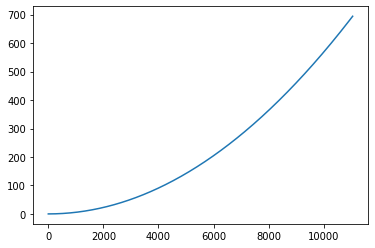

In [124]:
plt.plot(x0_, z0_)
plt.show()

In [125]:
init=1e-20
for j in range(1,12):
    if j==1:  
        q0[(j-1)*node_N:j*node_N]=x0_
    elif j==5:    
        q0[(j-1)*node_N:j*node_N]=z0_
#     elif j==9:    
#         q0[(j-1)*node_N:j*node_N]=init*rng.standard_normal(node_N)
#         q0[(j-1)*node_N]=0
#     elif j==11:   
#         q0[(j-1)*node_N:j*node_N]=init*rng.standard_normal(node_N)
#         q0[(j-1)*node_N]=0
    elif j==9:    
        q0[(j-1)*node_N:j*node_N]=np.array([-0.001*init for i in range(node_N)])
        q0[(j-1)*node_N]=0
    elif j==11:   
        q0[(j-1)*node_N:j*node_N]=np.array([-0.001*init for i in range(node_N)])
        q0[(j-1)*node_N]=0 
# q0[9*node_N-1]=0.13  # here

In [126]:
q0

array([ 0.        , 22.14966903, 44.29933805, ...,  0.        ,
        0.        ,  0.        ])

### Vessle Simulation

In [127]:
sampleTime = 0.01              # sample time [seconds]
N = 5000                      # number of samples

In [128]:
vehicle=semisub('DPcontrol',0,5,40.0,0,0) 

In [129]:
[simTime, simData] = simulate(N, sampleTime, vehicle)

In [130]:
ans_t=[]
sum_=0
for i in range(simData.shape[0]):
    ans_t.append(sum_)
    sum_+=sampleTime

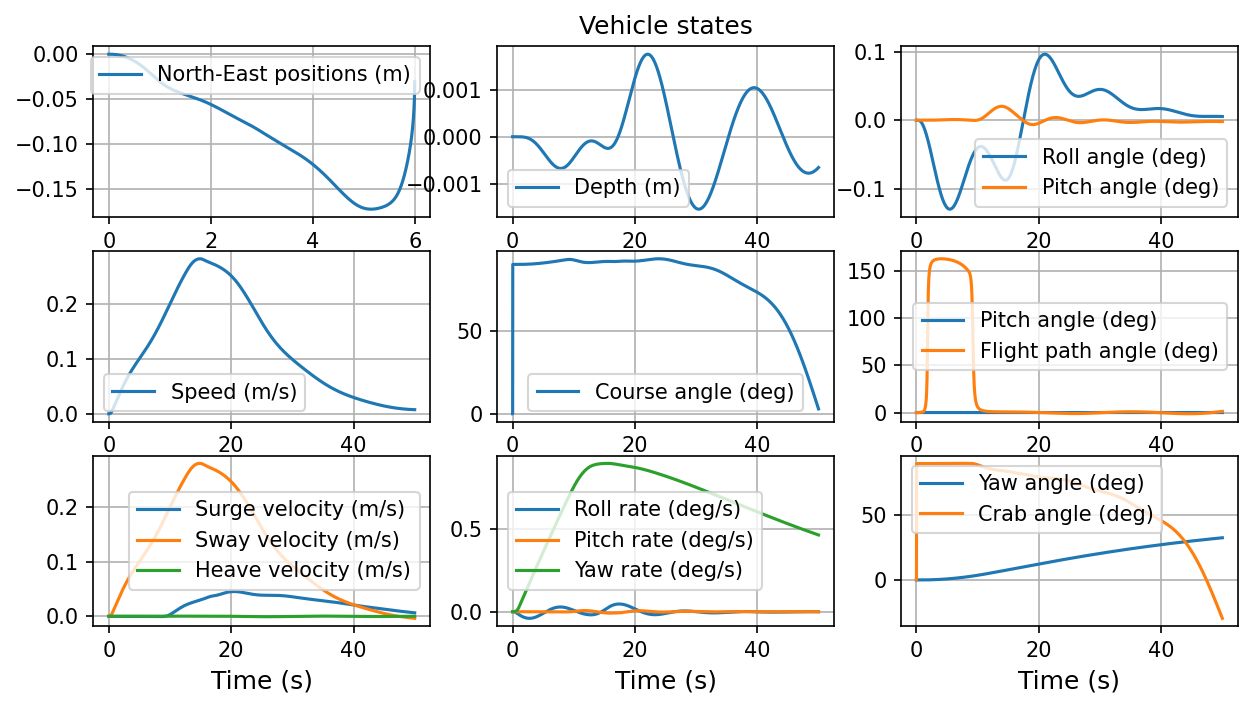

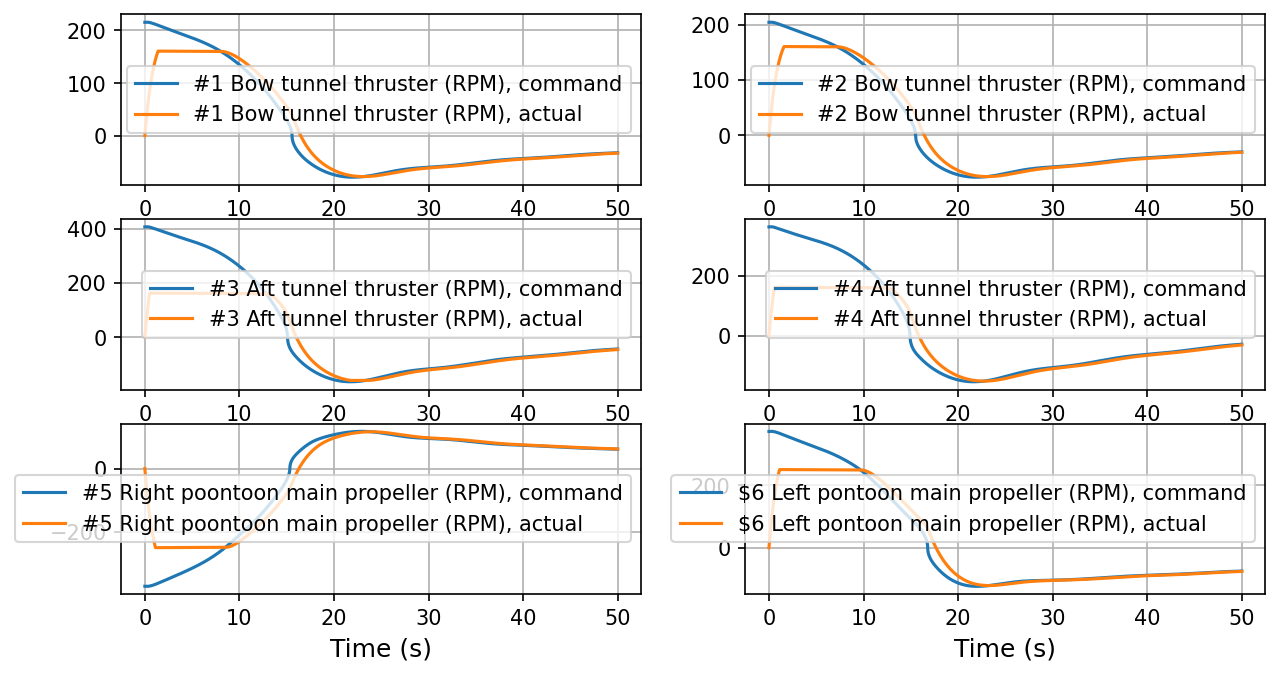

In [131]:
plotVehicleStates(simTime, simData, 1)                    
plotControls(simTime, simData, vehicle, 2)

In [132]:
numDataPoints = 5                 # number of 3D data points
FPS = 10                            # frames per second (animated GIF)
filename = '3D_animation.gif'       # data file for animated GIF
browser = 'safari'       

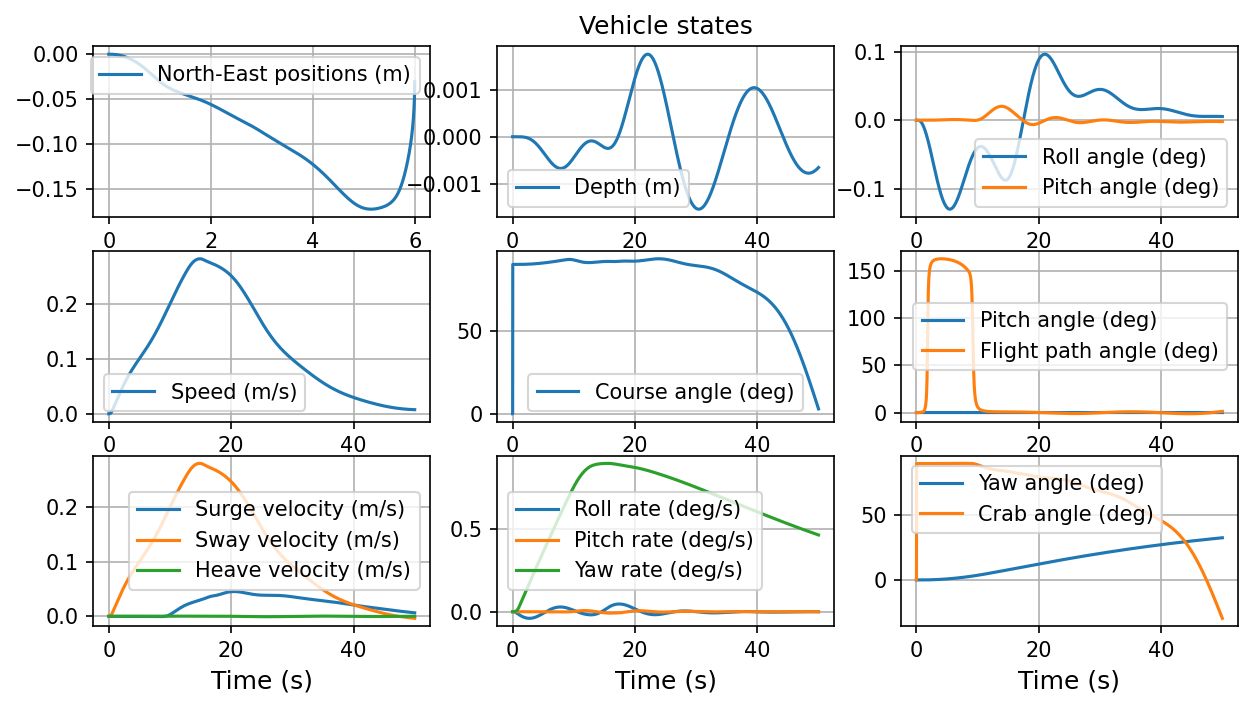

In [133]:
plotVehicleStates(simTime, simData, 3)

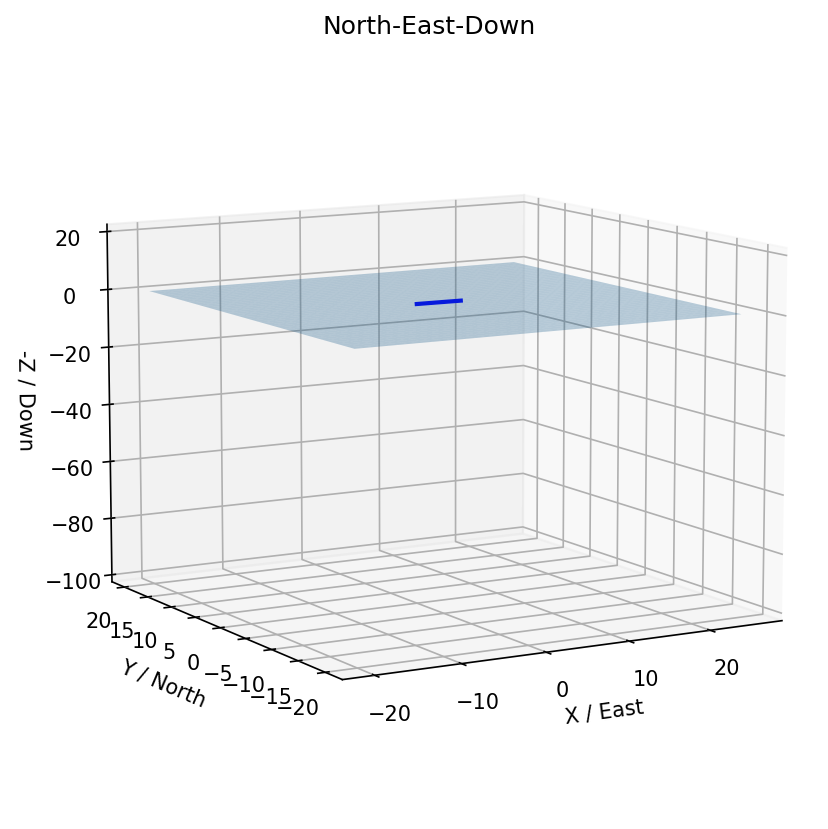

In [134]:
plot3D(simData, numDataPoints, FPS, filename, 3)  

In [135]:
def myDPcontrol(self, eta, nu, sampleTime):
        """
        u = DPcontrol(eta,nu,sampleTime) is a nonlinear PID controller
        for DP based on pole placement:

        tau = -R' Kp (eta-r) - R' Kd R nu - R' Ki int(eta-r)
        u = B_pseudoinverse * tau
        """
        # 3-DOF state vectors
        eta3 = np.array([eta[0], eta[1], eta[5]])
        nu3 = np.array([nu[0], nu[1], nu[5]])

        # 3-DOF diagonal model matrices
        M3 = np.diag([self.M[0][0], self.M[1][1], self.M[5][5]])
        D3 = np.diag([self.D[0][0], self.D[1][1], self.D[5][5]])

        [tau3, self.e_int, self.x_d, self.y_d, self.psi_d] = DPpolePlacement(
            self.e_int,
            M3,
            D3,
            eta3,
            nu3,
            self.x_d,
            self.y_d,
            self.psi_d,
            self.wn,
            self.zeta,
            self.ref,
            sampleTime,
        )
        
        tau=list(tau3)+[tau3[2]*ly - tau3[1]*lz,
                  tau3[0]*lz - tau3[2]*lx,
                  tau3[1]*lx - tau3[0]*ly]

#         u_alloc = self.controlAllocation(tau3)
        return tau

In [136]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [137]:
# Ws[0]*Ret[2]

In [138]:
# np.einsum('i,ijk->ijk',[Ws[i] for i in range(node_N)],Ret)

### Dynamics

In [139]:
def grayscott1d(t, Q): # here
#     print(t)
      
    x,y,z=Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]
    
    idx = find_nearest(np.array(ans_t),  t) 

    x_ve = simData[:, 0][idx]
    y_ve = simData[:, 1][idx]
#     x_ve = simData[:, 1][idx]
#     y_ve = simData[:, 0][idx]
    z_ve = simData[:, 2][idx]
    phi_ve = ssa(simData[:, 3][idx])
    theta_ve = ssa(simData[:, 4][idx])
    psi_v = ssa(simData[:, 5][idx])
    
    
    u_ve = simData[:, 6][idx]
    v_ve = simData[:, 7][idx]
#     u_ve = simData[:, 7][idx]
#     v_ve = simData[:, 6][idx]
    w_ve = simData[:, 8][idx]
    p_ve = simData[:, 9][idx]
    q_ve = simData[:, 10][idx]
    r_ve = simData[:, 11][idx]
    
    
    η=np.array([x_ve, y_ve, z_ve, phi_ve, theta_ve, psi_v])
    
    dη=np.array([u_ve, v_ve, w_ve, p_ve, q_ve, r_ve])
    
    
#     n_ = vehicle.DPcontrol(η,dη,sampleTime) # /1e3
    n_ = myDPcontrol(vehicle,η,dη,sampleTime)
#     print(n_)
    

    dx,dy,dz=Q[1*node_N:2*node_N],Q[3*node_N:4*node_N],Q[5*node_N:6*node_N]
    

    φ,θ,ψ=Q[6*node_N:7*node_N],Q[8*node_N:9*node_N],Q[10*node_N:11*node_N]
#     φ[-1],θ[-1],ψ[-1]=phi_ve, theta_ve,psi_v
    Ret = Re_t(φ,θ,ψ)
#     print(Ret)

    dφ,dθ,dψ=Q[7*node_N:8*node_N],Q[9*node_N:10*node_N],Q[11*node_N:12*node_N]
    
#     force_schedule =1/(1+np.exp(-np.exp(t/10)+np.exp(2)))
#     force_schedule = t/15 if t<15 else 1
#     force_schedule = 1e-1000
#     force_schedule=100
    force_schedule=1e-10
#     force_schedule=0
#     print(type(n_))
    tau_force = force_schedule*np.array(n_) # [N]
#     tau_force[0]=0
#     tau_force[1]=0
#     tau_force[2]=0
#     tau_force[3]=0
#     tau_force[4]=0
#     tau_force[5]=0

#     print(tau_force[:3])
    Z0=-np.dot(Re_b(Ret),tau_force[:3])
#     print(Ret)
#     print(Z0)
#     print(Z0)
    Z1 =d_s(ne, x, y, z, Ret,  ωe(φ,θ,ψ,None,None,None)).T
#     Z1 =d_s(ne, x, y, z, Ret, phi(x,y,z,Ret,None)).T
#     print(Z1)
    Z2=ne_(dx,dy,dz,DT,Ret).T
#     print(Z0)

    Z= (Z1 + Z2 +Z0
       )
#     Z[-1]+=tau_force[:3]

############################################################    
#     print(Ws)
    RRRR=Re_b(Ret)
#     print(Ret)
    ddx,ddy, ddz = np.linalg.solve(np.einsum('i,ijk->ijk',
                                             [Ws[i] for i in range(node_N)]
#                                              +[Ws[-1] + vessel_mass]
#                                              M_totl
                                          
                                             ,RRRR),
                                   Z
                                  ).T 
#     print(ddx)
#     print(np.concatenate([ddx, ddy,ddz, dφ,], axis=0))
#     ddx,ddy, ddz = Ret
    ddx,ddy, ddz = np.einsum('ijk,ik->ij',Ret, np.stack([ddx, ddy,ddz], axis=0).T).T
#     print(ddx)
#     print()
############################################################      

    sum_0123=0
    lll=[]
    for i in range(1,len(z0)):
        sum_0123=math.sqrt((x[i]-x[i-1])**2+(y[i]-y[i-1])**2+(z[i]-z[i-1])**2)
        lll.append(sum_0123)
#     print(lll)    
        
    cum_d_inv=[0]
    sum_=0
    for i in range(len(lll)-1,-1,-1):
        sum_+=lll[i]
        cum_d_inv.append(sum_)
    cum_d_inv=cum_d_inv[::-1]   
    
    Irho=inert(mn, vessel_inertia, Irho_, cum_d_inv, Ws)
#     print(Irho)
#     print()
 
    
 

    C1=np.einsum('ijk,ik->ij', Irho_e(Ret,Irho).astype(np.float64),
                                                        np.einsum('ijk,ik->ij', Π(dφ,dθ,dψ).astype(np.float64), 
                                                                  np.array([dφ,dθ,dψ]).astype(np.float64).T))
    
    test=np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float64),np.array([dφ,dθ,dψ]).astype(np.float64).T)
  
    C2= np.cross(
         test,
                 np.einsum('ijk,ik->ij',Irho_e(Ret,Irho).astype(np.float64),
                            test))


    C3=d_me(φ,θ,ψ,Ret, ωe, ωe(φ,θ,ψ,None,None,None))
#     print(C3)
    
#     C4= np.cross(d_s(phi,x,y,z,Ret, phi(x,y,z,Ret,None)).T, ne(x,y,z,Ret, phi(x,y,z,Ret,None)))
    C4= np.cross(d_s(phi,x,y,z,Ret, ωe(φ,θ,ψ,None,None,None)).T, 
                 ne(x,y,z,Ret, ωe(φ,θ,ψ,None,None,None),None))
#     print(C4)
#     print(tau_force[:3])
#     C4= np.cross(d_s(phi,x,y,z,Ret, test).T, ne(x,y,z,Ret, test))
    
    K1=test.T

    C5= np.einsum('ijk,ik->ij',Ret, -np.dot(DR,K1).astype(np.float64).T)

    C0=-np.einsum('ijk,kp->ijp',np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float64)),
                        Re_b(Ret)),tau_force[3:].reshape(3,1)) 
    B_ =(
        -C1
        -C2
        +C3
        +C4
        +C5
    )
    B= B_ +C0.squeeze()
#     print(C0,C1,C2,C3,C4)



#     print(B)   
    
#     print(Irho_e(Ret,Irho))
    A2 = Irho_e(Ret,Irho).astype(np.float64)
    A3=Π(φ,θ,ψ).astype(np.float64)

    A=np.einsum('ijk,ikr->ijr',A2,A3)
    

#     hack=1e18
    hack=1
############################################
    ddφ,ddθ,ddψ = np.linalg.solve(hack*A,B).T
#############################################


#     ddx[0],ddy[0],ddz[0],ddφ[0],ddθ[0],ddψ[0]=0,0,0,0,0,0
    A1111=np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ], axis=0)
#     print(A1111)
    return A1111

In [140]:
# import scipy

In [141]:
# ode15s = scipy.integrate.ode(grayscott1d)
# ode15s.set_integrator('vode', method='bdf', order=15, nsteps=3000)
# # ode15s.set_integrator('vode',  order=32, nsteps=3000)
# ode15s.set_initial_value(q0, 0)

In [142]:
# us=ode15s.integrate(10)

In [172]:
tspan = (0., 0.5)

In [173]:
startTime1 = datetime.now()

us=solve_ivp(grayscott1d,  tspan, q0, 
#              nfev=842
#              method='LSODA',
#              method= 'BDF'
#              vectorized=True
#              min_step=1e-6
#              rtol=1e9, atol=1e9
            )
print(datetime.now() - startTime1)

0:00:16.266644


In [174]:
# key takeaway: one can calibrate the model by tuning bc(init) and force_schedule 

### Results

In [175]:
fin=us

In [176]:
fin

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 104
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([0.        , 0.01037553, 0.11413086, 0.27202618, 0.34531321,
       0.3981595 , 0.44217565, 0.45916936, 0.47616307, 0.48696413,
       0.4977652 , 0.5       ])
 t_events: None
        y: array([[ 0.00000000e+00, -3.77820580e-13, -4.57162992e-11, ...,
        -8.32315085e-10, -8.69651797e-10, -8.77479327e-10],
       [ 2.21496690e+01,  2.21496690e+01,  2.21496690e+01, ...,
         2.21496690e+01,  2.21496690e+01,  2.21496690e+01],
       [ 4.42993381e+01,  4.42993381e+01,  4.42993381e+01, ...,
         4.42993381e+01,  4.42993381e+01,  4.42993381e+01],
       ...,
       [ 0.00000000e+00, -7.35299148e-15, -1.86798962e-12, ...,
        -3.61579366e-04, -6.55064647e-04, -7.40766385e-04],
       [ 0.00000000e+00, -7.35078490e-15, -1.87249264e-12, ...,
        -3.67160036e-04, -6.65486998e-04, -7.52625282e-0

In [177]:
t=fin.t

In [178]:
fin=fin.y.T

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  


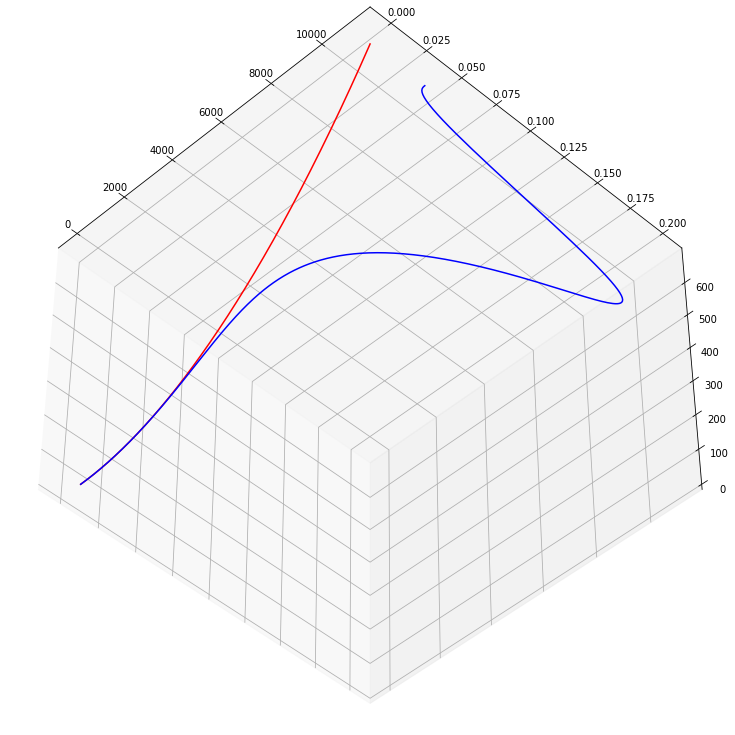

In [179]:
fig=plt.figure(figsize=(13,13))
ax = fig.gca(projection='3d')

X0=fin[0,[i for i in range(0,node_N)]]
Y0=fin[0,[i for i in range(2*node_N,3*node_N)]]
Z0=fin[0,[i for i in range(4*node_N,5*node_N)]]

j=-1
X=fin[j,[i for i in range(0,node_N)]]
Y=fin[j,[i for i in range(2*node_N,3*node_N)]]
Z=fin[j,[i for i in range(4*node_N,5*node_N)]]

num_true_pts = 200
tck, u = interpolate.splprep([X,Y,Z], s=2)
u_fine = np.linspace(0,1,num_true_pts)
x_fine, y_fine, z_fine = interpolate.splev(u_fine, tck)


ax.plot(X0,Y0,Z0, color='r')
ax.plot(X,Y,Z, color='b') 
# ax.plot(x_fine, y_fine, z_fine, color='b')
ax.view_init(-45,-45)

# ax.view_init(0,-90)
plt.show()

In [180]:
X,Y,Z

(array([-8.77479327e-10,  2.21496690e+01,  4.42993381e+01,  6.64490071e+01,
         8.85986761e+01,  1.10748345e+02,  1.32898014e+02,  1.55047683e+02,
         1.77197352e+02,  1.99347021e+02,  2.21496690e+02,  2.43646359e+02,
         2.65796028e+02,  2.87945697e+02,  3.10095366e+02,  3.32245035e+02,
         3.54394704e+02,  3.76544373e+02,  3.98694042e+02,  4.20843712e+02,
         4.42993381e+02,  4.65143050e+02,  4.87292719e+02,  5.09442388e+02,
         5.31592057e+02,  5.53741726e+02,  5.75891395e+02,  5.98041064e+02,
         6.20190733e+02,  6.42340402e+02,  6.64490071e+02,  6.86639740e+02,
         7.08789409e+02,  7.30939078e+02,  7.53088747e+02,  7.75238416e+02,
         7.97388085e+02,  8.19537754e+02,  8.41687423e+02,  8.63837092e+02,
         8.85986761e+02,  9.08136430e+02,  9.30286099e+02,  9.52435768e+02,
         9.74585437e+02,  9.96735106e+02,  1.01888478e+03,  1.04103444e+03,
         1.06318411e+03,  1.08533378e+03,  1.10748345e+03,  1.12963312e+03,
         1.1

In [181]:
X0,Y0,Z0

(array([    0.        ,    22.14966903,    44.29933805,    66.44900708,
           88.59867611,   110.74834513,   132.89801416,   155.04768319,
          177.19735222,   199.34702124,   221.49669027,   243.6463593 ,
          265.79602832,   287.94569735,   310.09536638,   332.2450354 ,
          354.39470443,   376.54437346,   398.69404249,   420.84371151,
          442.99338054,   465.14304957,   487.29271859,   509.44238762,
          531.59205665,   553.74172567,   575.8913947 ,   598.04106373,
          620.19073276,   642.34040178,   664.49007081,   686.63973984,
          708.78940886,   730.93907789,   753.08874692,   775.23841594,
          797.38808497,   819.537754  ,   841.68742303,   863.83709205,
          885.98676108,   908.13643011,   930.28609913,   952.43576816,
          974.58543719,   996.73510621,  1018.88477524,  1041.03444427,
         1063.18411329,  1085.33378232,  1107.48345135,  1129.63312038,
         1151.7827894 ,  1173.93245843,  1196.08212746,  1218.23

In [182]:
us=fin.T

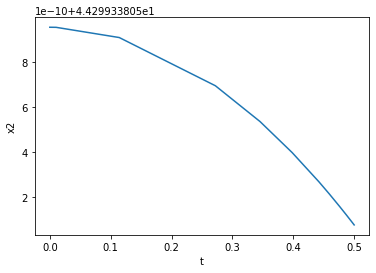

In [183]:
plt.plot(t,us.T[:,2],'-')
plt.xlabel('t')
plt.ylabel('x2')
plt.show()

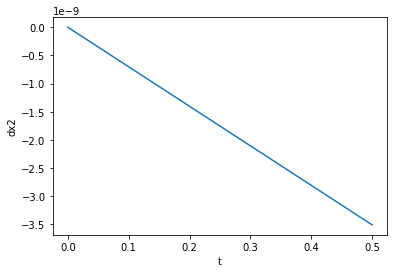

In [184]:
plt.plot(t,us.T[:,node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dx2')
plt.show()

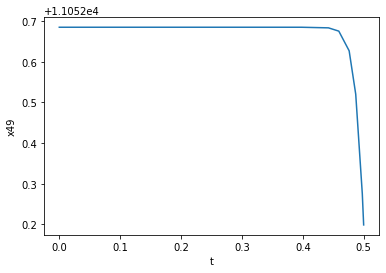

In [185]:
plt.plot(t,us.T[:,node_N-1] ,'-')
plt.xlabel('t')
plt.ylabel('x49')
plt.show()

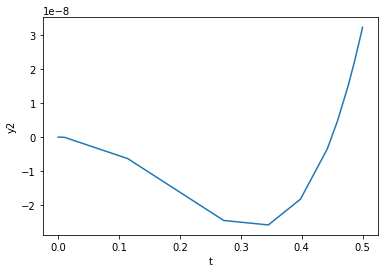

In [186]:
plt.plot(t,us.T[:,2*node_N +2] ,'-')
plt.xlabel('t')
plt.ylabel('y2')
plt.show()

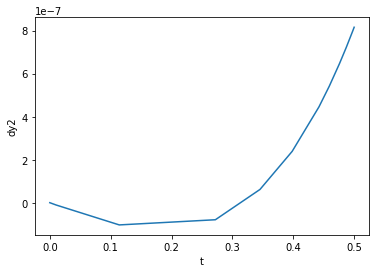

In [187]:
plt.plot(t,us.T[:,3*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dy2')
plt.show()

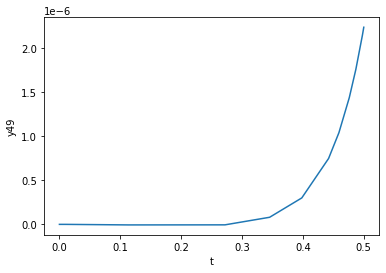

In [188]:
plt.plot(t,us.T[:,2*node_N+49] ,'-')
plt.xlabel('t')
plt.ylabel('y49')
plt.show()

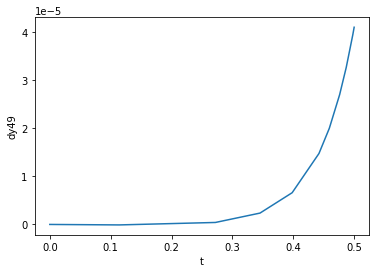

In [189]:
plt.plot(t,us.T[:,3*node_N+49] ,'-')
plt.xlabel('t')
plt.ylabel('dy49')
plt.show()

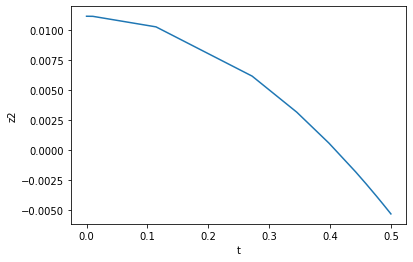

In [190]:
plt.plot(t,us.T[:,4*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('z2')
plt.show()

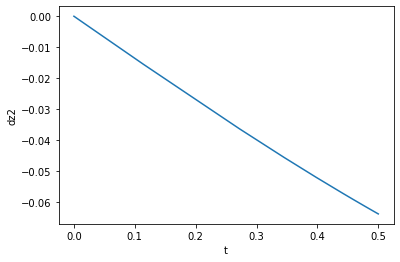

In [191]:
plt.plot(t,us.T[:,5*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dz2')
plt.show()

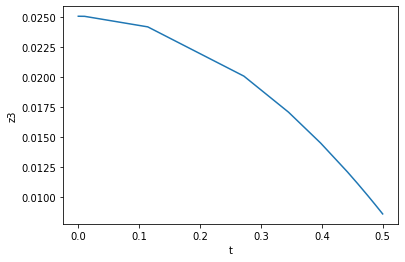

In [192]:
plt.plot(t,us.T[:,4*node_N+3] ,'-')
plt.xlabel('t')
plt.ylabel('z3')
plt.show()

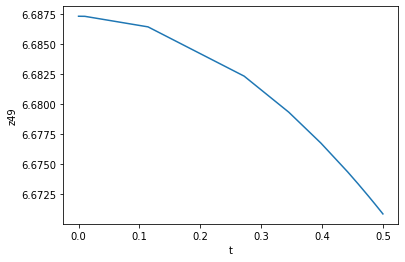

In [193]:
plt.plot(t,us.T[:,4*node_N+49] ,'-')
plt.xlabel('t')
plt.ylabel('z49')
plt.show()

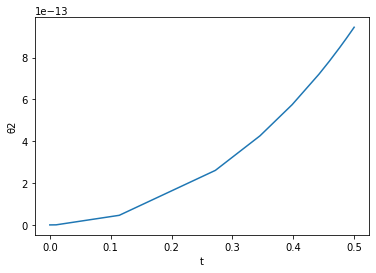

In [194]:
plt.plot(t,us.T[:,8*node_N+2],'-')
plt.xlabel('t')
plt.ylabel('θ2')
plt.show()

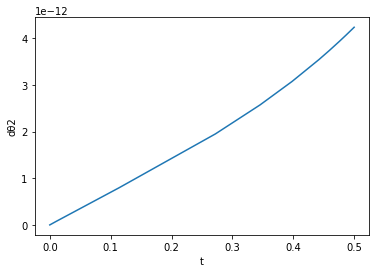

In [195]:
plt.plot(t,us.T[:,9*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dθ2')
plt.show()

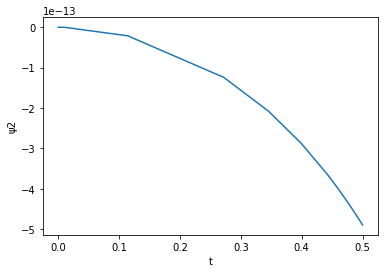

In [196]:
plt.plot(t,us.T[:,10*node_N+2],'-')
plt.xlabel('t')
plt.ylabel('ψ2')
plt.show()

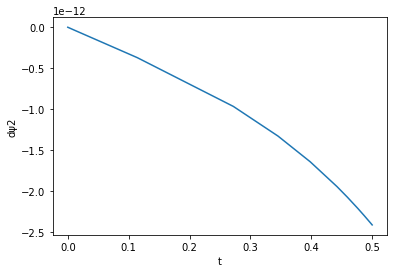

In [197]:
plt.plot(t,us.T[:,11*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dψ2')
plt.show()